In [19]:
import pandas as pd
import json
import plotly

In [20]:
# import plotly.io as pio
# pio.renderers.default = 'browser'

In [21]:
# with open("ea_results.json") as json_file:
with open("anneal_results.json") as json_file:
    data = json.load(json_file)

In [22]:
new_data = {}
row_number = 1
for generation, values in data.items():
    for individual, individual_values in values.items():
        if "agg_fitness" in individual_values.keys():
            new_data.update({str(row_number): {"Generation": int(generation), "population_number": int(individual), 
                                       "agg_fitness": individual_values["agg_fitness"],
                                       "cost": individual_values["fitness"][3],
                                       "throughput_time": individual_values["fitness"][2],
                                       "throughput": individual_values["fitness"][0],
                                       "wip": individual_values["fitness"][1],
                                      }})
            row_number += 1
df = pd.DataFrame(new_data)
df = df.T

In [23]:
df.head()

,Generation,population_number,agg_fitness,cost,throughput_time,throughput,wip
1,0.0,0.0,860.186283,0.0,459.280601,714.0,472.305682
2,0.0,1.0,1519.841433,0.0,205.265928,105.0,1325.075505
3,0.0,2.0,1519.841433,0.0,205.265928,105.0,1325.075505
4,0.0,3.0,1633.843638,40000.0,212.840650,107.0,1231.702988
5,0.0,4.0,1633.843638,40000.0,212.840650,107.0,1231.702988


In [24]:
df.shape

(2541, 7)

In [25]:
# df = df.drop_duplicates(subset=['agg_fitness'])
df = df.loc[df["agg_fitness"] > -50000]
df = df.loc[df["agg_fitness"] < 100000]

In [26]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [27]:
import numpy as np

In [28]:
df["cost"] = df["cost"].astype(float)
df["agg_fitness"] = df["agg_fitness"].astype(float)

In [29]:
df = df.loc[df["wip"] < 150]
df = df.loc[df["throughput"] > 2500]
df = df.loc[df["throughput_time"] < 100]

In [30]:
df.tail()

,Generation,population_number,agg_fitness,cost,throughput_time,throughput,wip
2535,0.0,2534.0,-52.164063,45000.0,39.792260,3338.0,16.843677
2536,0.0,2535.0,-38.708295,45000.0,48.819922,3324.0,19.871783
2538,0.0,2537.0,-235.050507,5000.0,54.204523,3366.0,22.344971
2540,0.0,2539.0,-51.418084,50000.0,28.636694,3425.0,12.445222
2541,0.0,2540.0,-232.706334,5000.0,56.008292,3373.0,23.585374


In [31]:
print(len(df))

914


In [32]:
columns = ['cost', 'throughput', 'wip']
# columns = ['throughput_time', 'throughput']
df_for_pareto = df[columns].copy()
df_for_pareto['throughput'] = -df_for_pareto['throughput']

In [33]:
is_efficient = is_pareto_efficient(df_for_pareto.values)
df['is_efficient'] = is_efficient

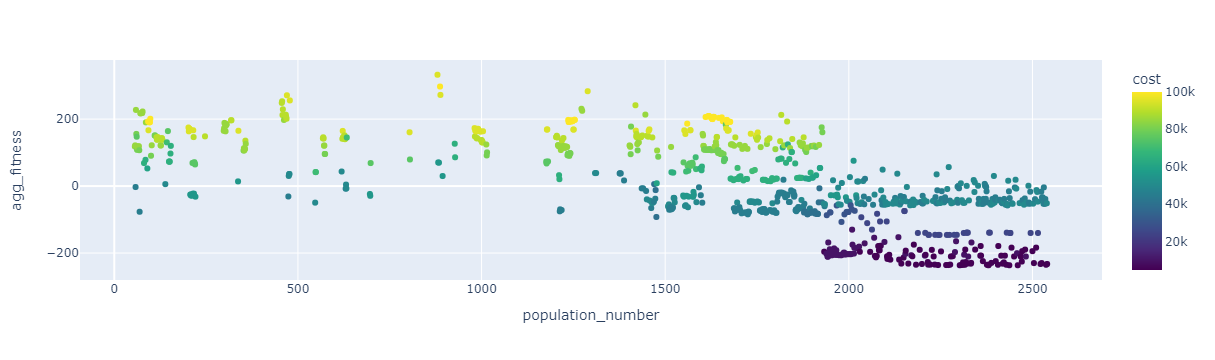

In [34]:
import plotly.express as px

fig = px.scatter(df, x='population_number', y='agg_fitness', hover_data=['cost', 'Generation', 'population_number', 'agg_fitness'],
              color=df['cost'], color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

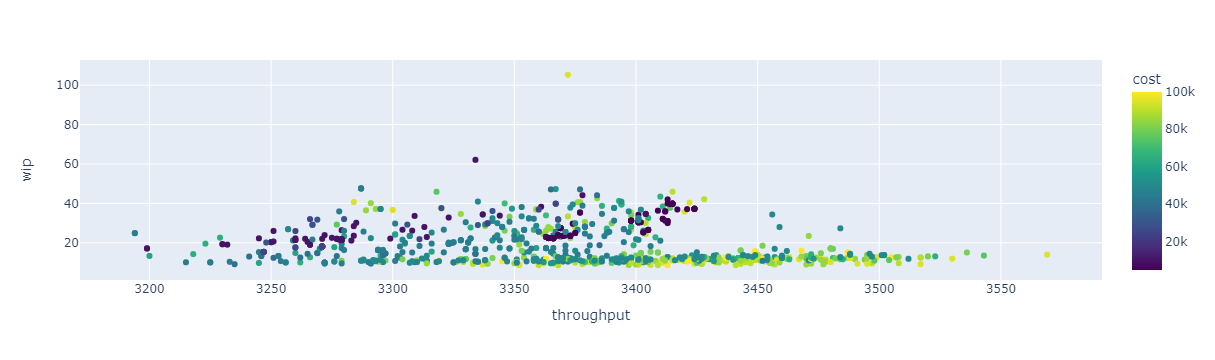

In [35]:
import plotly.express as px

fig = px.scatter(df, x='throughput', y='wip', hover_data=['cost', 'Generation', 'population_number', 'agg_fitness'],
              color=df['cost'], color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

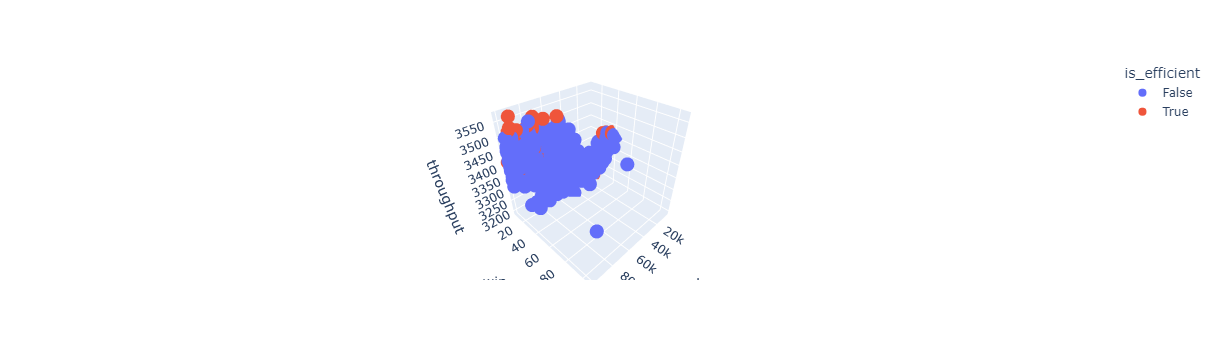

In [36]:
import plotly.express as px

fig = px.scatter_3d(df, x='cost', y='wip', z='throughput', hover_data=['cost', 'Generation', 'population_number', 'agg_fitness'],
              color=df['is_efficient'], color_continuous_scale=px.colors.sequential.Plotly3)
fig.show()

In [37]:
df.shape

(914, 8)

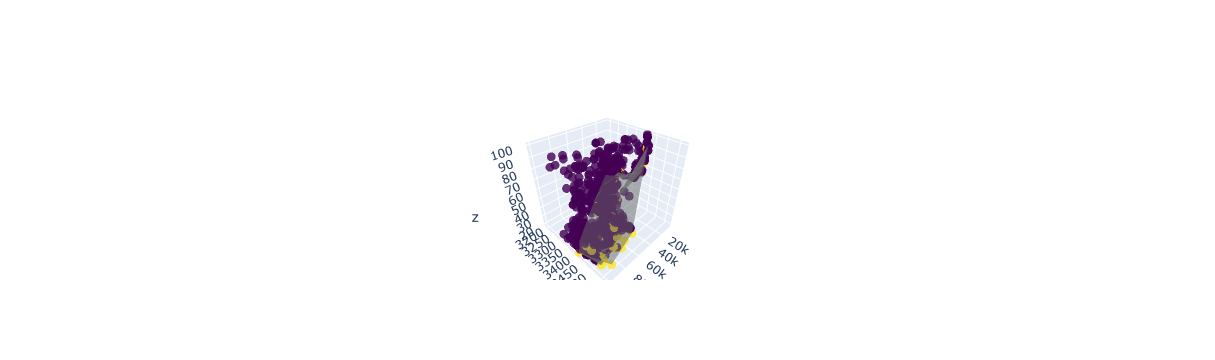

In [38]:
import plotly.graph_objects as go
import numpy as np

x = df['cost']
y = df['throughput']
z = df['throughput_time']
is_efficient = df['is_efficient'].astype(int)

data = [go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers', marker=dict(
        size=5,
        color=is_efficient,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    ))]

df_efficient = df.loc[df['is_efficient']]

x2 = df_efficient['cost']
y2 = df_efficient['throughput']
z2 = df_efficient['throughput_time']

data.append(go.Mesh3d(x=x2, y=y2, z=z2, color='grey', opacity=0.5))
fig = go.Figure(data=data)
fig.show()

In [39]:
df = pd.DataFrame(new_data)
df = df.T

In [40]:
df = df.loc[df["agg_fitness"] > -50000]
# df = df.loc[df['Generation'] > 10]

In [41]:
grouped = df.groupby(by="Generation")
mean_values = grouped["agg_fitness"].mean()
std_values = grouped["agg_fitness"].std()
max_values = grouped["agg_fitness"].max()

In [42]:
import plotly.graph_objects as go
from copy import copy

In [43]:
def hex_to_rgba(h, alpha):
    '''
    converts color value in hex format to rgba format with alpha transparency
    '''
    return tuple([int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)] + [alpha])

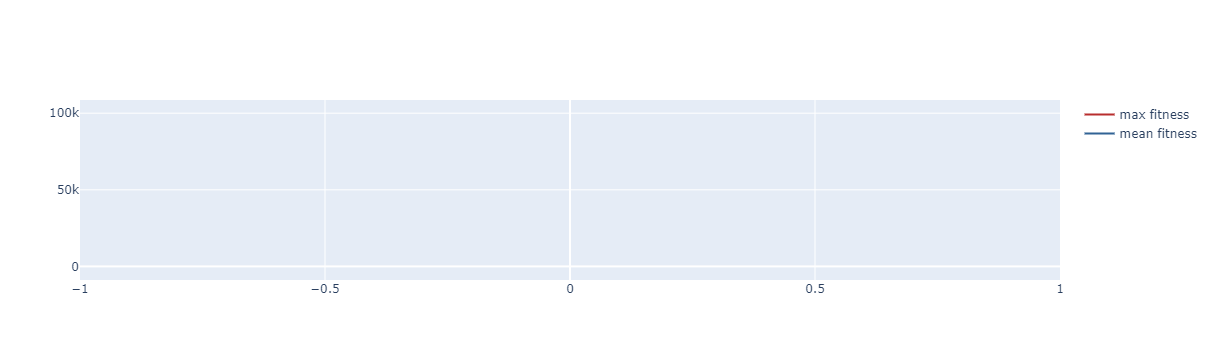

In [44]:
fig = go.Figure()        
colors = copy(px.colors.qualitative.G10)
color=colors.pop()
fig.add_scatter(
    name="mean fitness",
    x=mean_values.index,
    y=mean_values,
    mode="lines",
    line=dict(color=color)
            )
fig.add_scatter(
    name="upper fitness",
    x=mean_values.index,
    y=mean_values - std_values,
    mode="lines",
    line=dict(dash='dash', color=color), showlegend=False
            )
fig.add_scatter(
    name="lower fitness",
    x=mean_values.index,
    y=mean_values + std_values,
    mode="lines",
    line=dict(dash='dash', color=color),
    fill="tonexty",
    fillcolor='rgba' + str(hex_to_rgba(color, 0.2)), showlegend=False
)
fig.add_scatter(
    name="max fitness",
    x=mean_values.index,
    y=max_values,
    mode="lines",
    line=dict(color=colors.pop())
)

fig.show()